In [ ]:
!pip install scipy==1.9.3 --force-reinstall

In [40]:
# import scipy
# def derivative(func, x0, dx=1e-6, n=1, order=3):
#     if n != 1 or order != 3:
#         raise NotImplementedError("Only n=1 and order=3 supported")
#     return (func(x0 + dx) - func(x0 - dx)) / (2 * dx)

# scipy.misc.derivative = derivative

import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from ADRpy import atmospheres as at
from importlib import reload
import helper_functions
helper_functions = reload(helper_functions)
from helper_functions import *
import specs
specs = reload(specs)
from specs import *
import airfoil_functions
airfoil_functions = reload(airfoil_functions)
from airfoil_functions import *
from airfoils import Airfoil

In [2]:
foil = Airfoil.NACA4('2412')
x,y = foil.all_points

foil_vt = Airfoil.NACA4('0012')
x_vt,y_vt = foil_vt.all_points

In [4]:
# Reynolds_numbers = [calculate_reynolds_number(80, 1, 0), calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = list(range(-15,30,1))  # degrees
# phases = ["takeoff", "cruise"]  # one per Re
# Reynolds_numbers = [calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = [29]  # degrees
# phases = ["cruise"]  # one per Re

# get_airfoil_params_with_flap_effect_naca(
#     airfoil_name="2412",
#     Reynolds_numbers=Reynolds_numbers,
#     deflection_angles=deflection_angles,
#     phases=phases
# )

In [3]:
deflections_dict = {}
deflection_angles = list(range(-15,31,1))  # degrees
phases = ["takeoff", "cruise"]  # one per Re
for def_angle in deflection_angles:
    for phase in phases:

        deflections_dict[f"{phase}_{def_angle}"] = load_xfoil_polar(f'ht_deflections/NACA2412_def ({def_angle} deg)_{phase}.plr')


In [4]:
# airfoil_coeffs_vs_alpha = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(200, 1, 3000))}.dat')
# airfoil_coeffs_vs_alpha_to = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(80, 1, 0))}.dat')
airfoil_coeffs_vs_alpha_vt = load_xfoil_polar(f'NACA 0012-{int(calculate_reynolds_number(200, 1, 3000))}.dat')



In [47]:





def cruise_trim_analysis(
    neutral_point_m,
    cg_from_nose,
    cl_cruise,
    tail_arm_m,
    eta_h,
    delta_cl_from_thrust,
    current_angle_of_attack,
    phase
):
    
    if ("cruise" in phase) or (phase == "loiter"):
        phase = "cruise"
    elif phase in ["takeoff", "landing"]:
        phase = "takeoff"

    dict_of_aero_coeffs_vs_deflections_at_alpha = {}
    for deg in range(-15,31,1):
        try:
            dict_of_aero_coeffs_vs_deflections_at_alpha[str(deg)] = get_coefficients_at_alpha(deflections_dict[f"{phase}_{deg}"], current_angle_of_attack + assumed_and_set["ht_incident_angle"])
        except Exception as e:
            print(deg, "---", e)

    delta_vs_alpha_frame = pd.DataFrame(dict_of_aero_coeffs_vs_deflections_at_alpha).T
    delta_vs_alpha_frame["alpha"] = delta_vs_alpha_frame.index.astype(int)
    
    
    required_cl_tail = ((cg_from_nose - neutral_point_m) * cl_cruise / tail_arm_m) + delta_cl_from_thrust

    
    ht_deflection_angle = get_row_for_cl(delta_vs_alpha_frame, required_cl_tail)["alpha"]
    
    
    return {
        "cl_tail_required": required_cl_tail,
        "delta_elevator_deg": ht_deflection_angle,
    }



In [50]:
def refine_design_from_iterable_constraints(hard_constraints, assumed_and_set, weights_dict_kg_no_fuel, iterable_constraints, target_error=0.02, max_iterations=10):
    # populate constants and constraints

    # try:
        current_values = iterable_constraints.copy()

        
        prev_values = iterable_constraints.copy()
        

        
        for i in range(max_iterations):

            ## cruise iterations

            # print(f"[Iter {i+1}] " + " | ".join([f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in current_values.items()]))
            
            h_tail_te_position = current_values["tail_arm_m"] + current_values["cruiseout_cg_from_nose_m"] + 0.75*current_values["h_tail_chord_m"]
            # print(current_values["fuselage_body_length_m"], h_tail_te_position)
            
            cruiseout_v_ms = kmh_to_ms(current_values["cruiseout_speed_kmh"])
            rho = get_air_density(hard_constraints["cruise_altitude_m"])
            current_values["wing_area_m2"] = calc_required_wing_area(current_values["mtow"], current_values["cruiseout_cl"], rho, cruiseout_v_ms)
            
            ## cruise out calculations
            # Aerodynamics 
            cruiseout_mtow = current_values["mtow"]
            current_values["cruiseout_cl"] = calc_cl_cruise(cruiseout_mtow, current_values["cruiseout_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["cruiseout_angle_of_attack_deg"] = get_row_for_cl(deflections_dict[f"cruise_0"], current_values["cruiseout_cl"])["alpha"] - assumed_and_set["wing_incident_angle"]
            current_values["cruiseout_cd"] = calc_cd_total(deflections_dict[f"cruise_0"]["CD"].min(), current_values["cruiseout_cl"], assumed_and_set["aspect_ratio"])
            current_values["cruiseout_lift_to_drag"] = current_values["cruiseout_cl"] / current_values["cruiseout_cd"]
            cruiseout_drag_n = 0.5 * rho * cruiseout_v_ms**2 * current_values["wing_area_m2"] * current_values["cruiseout_cd"]
            cruiseout_power_kw = cruiseout_drag_n * cruiseout_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["cruiseout_power_kw"] = cruiseout_power_kw

            # Engine interpolation
            cruiseout_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, cruiseout_power_kw)
            current_values["cruiseout_sfc"] = cruiseout_sfc_data["sfc_cruise"]
            current_values["cruiseout_rpm"] = cruiseout_sfc_data["rpm_cruise"]
            current_values["cruiseout_time"] = hard_constraints["target_station_distance_km"] / current_values["cruiseout_speed_kmh"] # in hours

            cruiseout_fuel_requirement = cruiseout_power_kw * current_values["cruiseout_time"] * current_values["cruiseout_sfc"] 

            ## loiter calculations
            # Aerodynamics 
            loiter_v_ms = kmh_to_ms(current_values["loiter_speed_kmh"])
            loiter_mtow = current_values["mtow"] - cruiseout_fuel_requirement
            current_values["loiter_cl"] = calc_cl_cruise(loiter_mtow, current_values["loiter_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["loiter_angle_of_attack_deg"] = get_row_for_cl(deflections_dict[f"cruise_0"], current_values["loiter_cl"])["alpha"] - assumed_and_set["wing_incident_angle"]
            current_values["loiter_cd"] = calc_cd_total(deflections_dict[f"cruise_0"]["CD"].min(), current_values["loiter_cl"], assumed_and_set["aspect_ratio"])
            current_values["loiter_lift_to_drag"] = current_values["loiter_cl"] / current_values["loiter_cd"]
            loiter_drag_n = 0.5 * rho * loiter_v_ms**2 * current_values["wing_area_m2"] * current_values["loiter_cd"]
            loiter_power_kw = loiter_drag_n * loiter_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["loiter_power_kw"] = loiter_power_kw

            # Engine interpolation
            loiter_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, loiter_power_kw)
            current_values["loiter_sfc"] = loiter_sfc_data["sfc_cruise"]
            current_values["loiter_rpm"] = loiter_sfc_data["rpm_cruise"]

            loiter_fuel_requirement = loiter_power_kw * hard_constraints["loiter_time"] * 1.1 * current_values["loiter_sfc"] 

            estimate_loiter_fuel = loiter_power_kw * hard_constraints["loiter_time"] * 1.1 * current_values["cruiseout_sfc"] ## 1.2 is a multiplier to estimate the increased SFC at the lower RPM during loiter
            

            ## cruise back calculations
            # Aerodynamics 
            cruiseback_v_ms = kmh_to_ms(current_values["cruiseback_speed_kmh"])
            cruiseback_mtow = current_values["mtow"] - cruiseout_fuel_requirement - loiter_fuel_requirement - hard_constraints["internal_payload_mass"] - hard_constraints["wing_payload_mass"]
            current_values["cruiseback_cl"] = calc_cl_cruise(cruiseback_mtow, current_values["cruiseback_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["cruiseback_angle_of_attack_deg"] = get_row_for_cl(deflections_dict[f"cruise_0"], current_values["cruiseback_cl"])["alpha"] - assumed_and_set["wing_incident_angle"]
            current_values["cruiseback_cd"] = calc_cd_total(deflections_dict[f"cruise_0"]["CD"].min(), current_values["cruiseback_cl"], assumed_and_set["aspect_ratio"])
            current_values["cruiseback_lift_to_drag"] = current_values["cruiseback_cl"] / current_values["cruiseback_cd"]
            cruiseback_drag_n = 0.5 * rho * cruiseback_v_ms**2 * current_values["wing_area_m2"] * current_values["cruiseback_cd"]
            cruiseback_power_kw = cruiseback_drag_n * cruiseback_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["cruiseback_power_kw"] = cruiseback_power_kw

            # Engine interpolation
            cruiseback_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, cruiseback_power_kw)
            current_values["cruiseback_sfc"] = cruiseback_sfc_data["sfc_cruise"]
            current_values["cruiseback_rpm"] = cruiseback_sfc_data["rpm_cruise"]
            current_values["cruiseback_time"] = hard_constraints["target_station_distance_km"] / current_values["cruiseback_speed_kmh"] # in hours

            cruiseback_fuel_requirement = cruiseback_power_kw * current_values["cruiseback_time"] * current_values["cruiseback_sfc"] 


            current_values["fuel_kg"] = cruiseout_fuel_requirement + estimate_loiter_fuel + cruiseback_fuel_requirement

            current_values["mtow"]  = sum(weights_dict_kg_no_fuel.values()) + current_values["fuel_kg"]

            # Wing geometry - stays fixed for following flight stages
            current_values["wing_area_m2"] = calc_required_wing_area(current_values["mtow"], current_values["cruiseout_cl"], rho, cruiseout_v_ms)
            current_values["wing_span_m"] = np.sqrt(current_values["wing_area_m2"] * assumed_and_set["aspect_ratio"])
            current_values["chord_m"] = current_values["wing_area_m2"] / current_values["wing_span_m"]
            current_values["wing_loading_pa"] = current_values["mtow"] * g / current_values["wing_area_m2"] 

            current_values["tail_arm_m"] = assumed_and_set["horizontal_tail_arm_mac_coeff"] * current_values["chord_m"]

            # --- Horizontal Tail Area (S_h) ---
            current_values["horizontal_tail_area_m2"] = assumed_and_set["horizontal_tail_volume_coefficient"] *  (current_values["wing_area_m2"] * current_values["chord_m"]) / current_values["tail_arm_m"]
            

            current_values["h_tail_span_m"], current_values["h_tail_chord_m"] = tail_geometry(current_values["horizontal_tail_area_m2"], assumed_and_set["AR_horizontal"])
            
            # --- Vertical Tail Area (S_v) ---
            current_values["vertical_tail_area_m2"] = assumed_and_set["vertical_tail_volume_coefficient"] *(current_values["wing_area_m2"] * current_values["wing_span_m"]) /current_values["tail_arm_m"]
            

            current_values["v_tail_span_m"], current_values["v_tail_chord_m"] = tail_geometry(current_values["vertical_tail_area_m2"], assumed_and_set["AR_vertical"])
            # current_values["v_tail_span_m"], current_values["v_tail_chord_m"] = tail_geometry(current_values["vertical_tail_area_m2"], 2.0)  # Assuming AR of 2.0 for vertical tail


            # --- Fuselage Geometry ---
            

            current_values["fuselage_body_length_m"] = initial_size_fuselage(hard_constraints, assumed_and_set, current_values, False)
            # current_values["fuselage_body_length_m"] = h_tail_te_position

            # current_values["fuselage_tail_arm_extension_m"] = max(0, h_tail_te_position - current_values["fuselage_body_length_m"])

            # if current_values["fuselage_tail_arm_extension_m"] == 0:
            wing_le_position_m = assumed_and_set["wing_le_position_fuselage_length_coeff"] * current_values["fuselage_body_length_m"]
            current_values["wing_le_position_m"] = wing_le_position_m
            

            # --- range, endurance, and fuel requirements ---

            cruise_fuel = cruiseout_fuel_requirement
            loiter_fuel = loiter_fuel_requirement

            cb = current_values["loiter_sfc"]
            rho = get_air_density(hard_constraints["cruise_altitude_m"])
            w_0 = (current_values["mtow"] - cruise_fuel ) * g
            w_f = (current_values["mtow"] - cruise_fuel - loiter_fuel) * g

            Breguet_endurance = current_values["loiter_lift_to_drag"] * (1/cb) * np.log(w_0/w_f)

            current_values["calculated_loiter_time"] = Breguet_endurance  # in hours

            ## fuel tank calculations
            current_values["required_fuel_volume_m3"] = current_values["fuel_kg"] / assumed_and_set["fuel_density_kgL"] / 1000
            current_values["max_theoretical_range"] = current_values["cruiseout_speed_kmh"]  * (current_values["fuel_kg"]/2) / (current_values["cruiseout_power_kw"] * current_values["cruiseout_sfc"])

            fuselage_cross_section_area = (current_values["fuselage_body_width_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02) *( current_values["fuselage_body_height_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02)
            fuselage_fuel_tank = assumed_and_set["fuselage_fuel_tank_length"] * fuselage_cross_section_area #cross_section_area_fuselage_fuel_tank(iterable_constraints["fuselage_diameter_m"], 0.8)
            wing_fuel_tank = wing_fuel_tank_volume("naca2412_coords.dat", current_values, 0.25, 0.65)
            current_values["space_available_for_fuel_m3"] = fuselage_fuel_tank + wing_fuel_tank
            
            if current_values["required_fuel_volume_m3"] < fuselage_fuel_tank:
                fuselage_fuel = current_values["fuel_kg"]
            else:
                fuselage_fuel = fuselage_fuel_tank * 1000 * assumed_and_set["fuel_density_kgL"]  

            wing_fuel = current_values["fuel_kg"] - fuselage_fuel

            # airframe mass estimation

            fuselage_mass = get_fuselage_mass(current_values["fuselage_body_length_m"], current_values["fuselage_body_width_m"], 
                                            current_values["fuselage_body_height_m"], assumed_and_set) * assumed_and_set["fuselage_internal_supports_mass_multiplier"]
            weights_dict_kg_no_fuel["fuselage"] = fuselage_mass

            wing_cross_section_perimeter_length = airfoil_perimeter_length(x, y, current_values["chord_m"])
            wing_mass = get_wing_or_tail_mass(current_values["wing_span_m"], wing_cross_section_perimeter_length,"wing", assumed_and_set) * assumed_and_set["wing_internal_supports_mass_multiplier"]
            weights_dict_kg_no_fuel["wing"] = wing_mass
            
            horizontal_tail_perimeter = airfoil_perimeter_length(x, y, current_values["h_tail_chord_m"])
            horizontal_tail_mass = get_wing_or_tail_mass(current_values["h_tail_span_m"], horizontal_tail_perimeter,"tail", assumed_and_set) * assumed_and_set["tail_internal_supports_mass_multiplier"]

            vertical_tail_perimeter = airfoil_perimeter_length(x_vt, y_vt, current_values["v_tail_chord_m"])
            vertical_tail_mass = get_wing_or_tail_mass(current_values["v_tail_span_m"], vertical_tail_perimeter,"tail", assumed_and_set) * assumed_and_set["tail_internal_supports_mass_multiplier"]
            
            weights_dict_kg_no_fuel["horizontal_tail"] = horizontal_tail_mass
            weights_dict_kg_no_fuel["vertical_tail"] = vertical_tail_mass
            weights_dict_kg_no_fuel["tails"] = horizontal_tail_mass + vertical_tail_mass
            
            #cg position estimation
            cruiseout_weights_for_cg = weights_dict_kg_no_fuel.copy()
            cruiseout_weights_for_cg["fuselage_fuel"] = fuselage_fuel
            cruiseout_weights_for_cg["wing_fuel"] = wing_fuel


            #post payload drop

            component_positions_m, component_positions_m_z = estimate_component_positions(current_values, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)
            ### cruise out stability and trim
            current_values["cruiseout_cg_from_nose_m"] = calculate_cg(cruiseout_weights_for_cg, component_positions_m)
            current_values["cruiseout_cg_from_floor_m"] = calculate_cg(cruiseout_weights_for_cg, component_positions_m_z)

            # cruise_out_stability_dict = stability_analysis(current_values["chord_m"], current_values["cruiseout_cg_from_nose_m"], 
            #                                             assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            cruise_out_stability_dict = stability_analysis(current_values, assumed_and_set, deflections_dict, "cruiseout")
            
            current_values["neutral_point_m"] = cruise_out_stability_dict["neutral_point_m"]
            current_values["cruiseout_static_margin"] = cruise_out_stability_dict["static_margin"]

            # print(f"Static Margin: {current_values['static_margin']:.4f} | Static Margin Post Drop: {post_drop_vals['static_margin']:.4f}")
            eta_h = calculate_eta_h(current_values, phase="cruiseout")
            
            wing_ac = current_values["wing_le_position_m"] + 0.25*current_values["chord_m"]

            phase_for_delta = "cruise"
            coeff_ratio = get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], 
                                          current_values['cruiseout_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CM", 0.1) /  get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], 
                                                                                                                                                                   current_values['cruiseout_angle_of_attack_deg'] + assumed_and_set["wing_incident_angle"], "CL", 0.1)
            current_values["cruiseout_x_ac_w_m"] = wing_ac - coeff_ratio * current_values["chord_m"]
            current_values["cruiseout_x_ht_ac_m"] = current_values["cruiseout_x_ac_w_m"] + current_values["tail_arm_m"]

            ## single time geometric value
            current_values["x_ht_le_m"] = current_values["cruiseout_x_ht_ac_m"] - 0.25 * current_values["h_tail_chord_m"]
            ###

            cruiseout_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "cruiseout")

            cruiseout_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseout_cg_from_nose_m"], 
                                                current_values["cruiseout_cl"], current_values["tail_arm_m"], eta_h, cruiseout_delt_cl_from_thrust, current_values["cruiseout_angle_of_attack_deg"], "cruiseout")
            
            current_values["cruiseout_cl_tail_required"] = cruiseout_trim_dict["cl_tail_required"]
            current_values["cruiseout_delta_elevator_deg"] = cruiseout_trim_dict["delta_elevator_deg"]

            current_values.update(calculate_Cn_beta_phase(current_values, hard_constraints, airfoil_coeffs_vs_alpha_vt, "cruiseout"))
            current_values.update(calculate_Cl_beta_phase(current_values, assumed_and_set, "cruiseout"))
            ### loiter stability and trim

            loiter_weights_for_cg = weights_dict_kg_no_fuel.copy()
            loiter_weights_for_cg["fuselage_fuel"] = min(fuselage_fuel - (wing_fuel - cruiseout_fuel_requirement), fuselage_fuel)
            loiter_weights_for_cg["wing_fuel"] = max(wing_fuel - cruiseout_fuel_requirement, 0)

            
            current_values["loiter_cg_from_nose_m"] = calculate_cg(loiter_weights_for_cg, component_positions_m)
            current_values["loiter_cg_from_floor_m"] = calculate_cg(loiter_weights_for_cg, component_positions_m_z)
            
            
            # loiter_stability_dict = stability_analysis(current_values["chord_m"], current_values["loiter_cg_from_nose_m"], 
            #                                             assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            loiter_stability_dict = stability_analysis(current_values, assumed_and_set, deflections_dict, "loiter")
            
            
            current_values["loiter_static_margin"] = loiter_stability_dict["static_margin"]

            eta_h = calculate_eta_h(current_values, phase="loiter")
            
            phase_for_delta = "cruise"
            coeff_ratio = get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['loiter_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['loiter_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CL", 0.1)
            current_values["loiter_x_ac_w_m"] = wing_ac - coeff_ratio * current_values["chord_m"]
            current_values["loiter_x_ht_ac_m"] = current_values["loiter_x_ac_w_m"] + current_values["tail_arm_m"]

            loiter_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "loiter")

            loiter_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["loiter_cg_from_nose_m"], 
                                                current_values["loiter_cl"], current_values["tail_arm_m"], eta_h, loiter_delt_cl_from_thrust, current_values["loiter_angle_of_attack_deg"], "loiter")
            
            current_values["loiter_cl_tail_required"] = loiter_trim_dict["cl_tail_required"]
            current_values["loiter_delta_elevator_deg"] = loiter_trim_dict["delta_elevator_deg"]

            current_values.update(calculate_Cn_beta_phase(current_values, hard_constraints, airfoil_coeffs_vs_alpha_vt, "loiter"))
            current_values.update(calculate_Cl_beta_phase(current_values, assumed_and_set, "loiter"))
            ### cruiseback stability and trim

            cruiseback_weights_for_cg = weights_dict_kg_no_fuel.copy()
            cruiseback_weights_for_cg["fuselage_fuel"] = min(fuselage_fuel - (wing_fuel - cruiseout_fuel_requirement), fuselage_fuel)
            cruiseback_weights_for_cg["wing_fuel"] = max(wing_fuel - cruiseout_fuel_requirement, 0)
            cruiseback_weights_for_cg["internal_payload"] = 0
            cruiseback_weights_for_cg["wing_payload"] = 0
            
            current_values["cruiseback_cg_from_nose_m"] = calculate_cg(cruiseback_weights_for_cg, component_positions_m)
            current_values["cruiseback_cg_from_floor_m"] = calculate_cg(cruiseback_weights_for_cg, component_positions_m_z)

            # cruiseback_stability_dict = stability_analysis(current_values["chord_m"], current_values["cruiseback_cg_from_nose_m"], 
            #                                             assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            cruiseback_stability_dict = stability_analysis(current_values, assumed_and_set, deflections_dict, "cruiseback")
            
            current_values["cruiseback_static_margin"] = cruiseback_stability_dict["static_margin"]

            # print(f"Static Margin: {current_values['static_margin']:.4f} | Static Margin Post Drop: {post_drop_vals['static_margin']:.4f}")
            eta_h = calculate_eta_h(current_values, phase="cruiseback")
            
            phase_for_delta = "cruise"
            coeff_ratio = get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['cruiseback_angle_of_attack_deg']   + assumed_and_set["wing_incident_angle"], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], current_values['cruiseback_angle_of_attack_deg']  + assumed_and_set["wing_incident_angle"], "CL", 0.1)
            current_values["cruiseback_x_ac_w_m"] = wing_ac - coeff_ratio * current_values["chord_m"]
            current_values["cruiseback_x_ht_ac_m"] = current_values["cruiseback_x_ac_w_m"] + current_values["tail_arm_m"]

            cruiseback_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "cruiseback")

            cruiseback_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseback_cg_from_nose_m"], 
                                                current_values["cruiseback_cl"], current_values["tail_arm_m"], eta_h, cruiseback_delt_cl_from_thrust, current_values["cruiseback_angle_of_attack_deg"], "cruiseout")
            
            current_values["cruiseback_cl_tail_required"] = cruiseback_trim_dict["cl_tail_required"]
            current_values["cruiseback_delta_elevator_deg"] = cruiseback_trim_dict["delta_elevator_deg"]
            
            current_values.update(calculate_Cn_beta_phase(current_values, hard_constraints, airfoil_coeffs_vs_alpha_vt, "cruiseback"))
            current_values.update(calculate_Cl_beta_phase(current_values, assumed_and_set, "cruiseback"))

            # print(current_values.keys())
            # print(prev_values.keys())
            
            relative_errors = {
                k: abs(current_values[k] - prev_values[k]) / max(abs(current_values[k]), 1e-6)
                for k in current_values
            }

            

            for iter_key in prev_values:
                prev_values[iter_key] = current_values[iter_key]  # ← updates global dict

            if all(err < target_error for err in relative_errors.values()):

                # for iter_key in iterable_constraints:
                #     iterable_constraints[iter_key] = current_values[iter_key]  # ← updates global dict
                    
                if current_values["required_fuel_volume_m3"] > current_values["space_available_for_fuel_m3"]:
                    print(f"❌ Design failed: Required fuel volume {current_values['required_fuel_volume_m3']:.5f} m³ exceeds available space {current_values['space_available_for_fuel_m3']:.5f} m³.")
                    return current_values
                
                
                print(f"Converged in {i+1} iterations.")
                return current_values



        
        return current_values
    # except Exception as e:
    #     print("Design iteration did not converge.")
    #     return current_values

In [72]:

assumed_and_set = {
    # Mission requirements
    "rolling_resistance_coefficient": 0.04, # dimensionless   
    "target_drop_altitude_m": 2500,
    "sea_level_air_density": get_air_density(0),
    "horizontal_tail_volume_coefficient": 0.35, # dimensionless
    "vertical_tail_volume_coefficient": 0.04, # Computed Vv
    "horizontal_tail_arm_mac_coeff": 2.5, # dimensionless
    "tail_mass_cg_from_le_coeff": 0.4,
    "ht_downwash_efficiency_coeff": 0.5,
    # "fuselage_length_mac_coeff": 5, # dimensionless
    "wing_le_position_fuselage_length_coeff": 0.35, # dimensionless
    # Configuration
    "fuel_density_kgL": 0.74,
    "gfrp_thickness_m": 0.0015, # meters
    "gfrp_density_kgm3": 2150, # kg/m^3
    "core_density_kgm3": 60,
    "fuselage_fuel_tank_length": 0.55, #meters
    "fuselage_internal_supports_mass_multiplier": 1.3,
    "wing_internal_supports_mass_multiplier": 1.3,
    "tail_internal_supports_mass_multiplier": 1.1,
    "aspect_ratio": 14  , # starting assumption
    "AR_horizontal": 4.0,                # aspect ratio of horizontal tail
    "AR_vertical": 2.0,                  # aspect ratio of vertical tail
    # "cl_alpha" : 8.44, # cl / angle of attack slope in (rad). taken from airfoil data
    "loiter_drag_multiplier": 1.05, ## assumes 5% extra drag due to turns, lower speed, and loss of energy
    "dihedral_deg": 4.0,                        # Wing dihedral angle (degrees)
    "wing_sweep_deg": 0.0,                      # Wing sweep at 25% chord (degrees)
    "wing_incident_angle" : 4,                  ## degrees
    "ht_incident_angle": -3.5,                    ## degrees
    "high_wing_offset_m": 0.0,                  # Vertical distance from fuselage centerline to wing root (m)
    "elevator_chord_fraction": 0.35,            # Fraction of HT chord used for elevator
    "elevator_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)  
    "rudder_chord_fraction": 0.35,              # Fraction of VT chord used for rudder
    "rudder_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)    
    "wing_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 2412) same used for horizontal tail
    "vertical_tail_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 0012)
}

hard_constraints = {
    "wing_payload_mass" : 50, # kg
    "internal_payload_mass": 0, #kg
    "internal_payload_length": 0, # meter
    "target_station_distance_km": 100,
    "loiter_time": 1, # hours
    "takeoff_distance_max_m": 50, # dirt road
    "climb_time_min": 13, # minutes
    "cruise_altitude_m": 3000,  
}

weights_dict_kg_no_fuel = {
    "fuselage": 40,
    "wing": 230,
    "tails": 10,
    "internal_payload": hard_constraints["internal_payload_mass"],
    "wing_payload": hard_constraints["wing_payload_mass"],
    "engine": engine_specs["dry_weight_kg"],
    "propeller": propeller_specs["weight_kg"],
    "avionics": 10,
    "landing_gear": 20,
    "misc": 10,
}

iterable_constraints = {

    ## structural design variables
    #################################
    "wing_area_m2": 16, # starting assumption
    "wing_loading_pa": 500,
    "wing_span_m": 16, # meters
    "chord_m": 1,  # meters
    "neutral_point_m": 2.5, # meters
    "wing_le_position_m": 1.2824, # meters — same as before
    "rudder_area_m2": 0.0,                      # Area of rudder
    "elevator_area_m2": 0.0,                     # Area of elevator
    ## fuselage square section "body"
    "fuselage_body_length_m": 4.9,     # meters — same as before
    "fuselage_body_width_m": 0.62,     # meters — same as before
    "fuselage_body_height_m": 0.45,     # meters — same as before
    "fuselage_tail_arm_extension_m": 0, # meter
    ## fuselage nose section



    "space_available_for_fuel_m3": 0.05, # available space for fuel (m^3)

    "tail_arm_m": 2.3659,  # meters
    "tail_boom_pylon_height_m": 0.25, # meters
    
    "horizontal_tail_area_m2": 0.4351,    # square meters
    "h_tail_chord_m": 0.2579,               # meters
    "h_tail_span_m": 1.0,                  # meters
    "x_ht_le_m": 4.5,

    "vertical_tail_area_m2": 0.1741,      # square meters
    "v_tail_chord_m": 0.1741,              # meters
    "v_tail_span_m": 1.0,                  # meters

    ## performance design variables
    ###################################
    "required_fuel_volume_m3": 0.02, # required fuel volume (m^3)
    "max_theoretical_range": 1.25*hard_constraints["target_station_distance_km"], # maximum theoretical range (km)
    "stall_speed_kmh": 55, # stall speed (km/h)
    "fuel_kg": 30, # kg starting assumption
    "mtow": sum(weights_dict_kg_no_fuel.values()) + 30, # starting assumption


    ## cruise out variables
    ##############################
    "cruiseout_speed_kmh": 150, #km/h
    "cruiseout_wing_loading_pa": 180, # starting assumption
    "cruiseout_cg_from_nose_m": 3.17574253884845,                # meters
    "cruiseout_cg_from_floor_m": 0.3,                # meters
    "cruiseout_cl": 0.8, # lift coefficient at cruise
    "cruiseout_cd" : 0.05, # drag coefficient at cruise
    "cruiseout_lift_to_drag": 16, # lift-to-drag ratio at cruise
    "cruiseout_sfc": 0.5, # specific fuel consumption at cruise (kg/kWh)
    "cruiseout_rpm": 5000, # engine RPM at cruise
    "cruiseout_power_kw": 8, # power required at cruise (kW)
    "cruiseout_static_margin": 0.1, # static margin (dimensionless)
    "cruiseout_delta_elevator_deg": 5, # elevator deflection angle (degrees)
    "cruiseout_cl_tail_required": -0.04, # required lift coefficient for tail
    "cruiseout_angle_of_attack_deg": 5, 
    "cruiseout_x_ac_w_m": 1.5,
    "cruiseout_x_ht_ac_m": 5,
    "cruiseout_Cn_beta": 0.0,           # Yaw stability derivative (1/rad)
    "cruiseout_Cl_beta": 0.0,           # Roll due to sideslip (1/rad)
    "cruiseout_Cn_r": 0.0,              # Yaw from rudder deflection (1/rad)
    "cruiseout_Cl_r": 0.0,              # Roll from rudder (adverse roll, 1/rad)
    "cruiseout_Re_vt": 0.0,             # Reynolds number for vertical tail
    "cruiseout_time": 3, # cruise time (hours)

    ## loiter variables
    ###############################
    "loiter_speed_kmh": 150, #km/h
    "loiter_wing_loading_pa": 180, # starting assumption
    "loiter_cg_from_nose_m": 3.17574253884845,                # meters
    "loiter_cg_from_floor_m": 0.25,                # meters
    "loiter_cl": 0.8, # lift coefficient at loiter
    "loiter_cd" : 0.05, # drag coefficient at loiter
    "loiter_lift_to_drag": 16, # lift-to-drag ratio at loiter
    "loiter_sfc": 0.5, # specific fuel consumption at loiter (kg/kWh)
    "loiter_rpm": 5000, # engine RPM at loiter
    "loiter_power_kw": 8, # power required at loiter (kW)
    "loiter_static_margin": 0.1, # static margin (dimensionless)
    "loiter_delta_elevator_deg": 5, # elevator deflection angle (degrees)
    "loiter_x_ac_w_m": 1.5,
    "loiter_x_ht_ac_m": 5,    
    "loiter_cl_tail_required": -0.04, # required lift coefficient for tail
    "loiter_angle_of_attack_deg": 5, 
    "loiter_Cn_beta": 0.0,              # Yaw stability derivative (1/rad)
    "loiter_Cl_beta": 0.0,              # Roll due to sideslip (1/rad)
    "loiter_Cn_r": 0.0,                 # Yaw from rudder (1/rad)
    "loiter_Cl_r": 0.0,                 # Roll from rudder (1/rad)
    "loiter_Re_vt": 0.0,                # Reynolds number for vertical tail
    
    "calculated_loiter_time": hard_constraints["loiter_time"],
    
    ## cruise back variables
    ###############################

    "cruiseback_speed_kmh": 130,
    "cruiseback_wing_loading_pa": 180, # starting assumption
    "cruiseback_cg_from_nose_m": 3.17574253884845,                # meters
    "cruiseback_cg_from_floor_m": 0.25,                # meters
    "cruiseback_cl": 0.8, # lift coefficient at cruiseback
    "cruiseback_cd" : 0.05, # drag coefficient at cruiseback
    "cruiseback_lift_to_drag": 16, # lift-to-drag ratio at cruiseback
    "cruiseback_sfc": 0.5, # specific fuel consumption at cruiseback (kg/kWh)
    "cruiseback_rpm": 5000, # engine RPM at cruiseback
    "cruiseback_power_kw": 8, # power required at cruiseback (kW)
    "cruiseback_static_margin": 0.1, # static margin (dimensionless)
    "cruiseback_delta_elevator_deg": 5, # elevator deflection angle (degrees)
    "cruiseback_cl_tail_required": -0.04, # required lift coefficient for tail
    "cruiseback_x_ac_w_m": 1.5,
    "cruiseback_x_ht_ac_m": 5, 
    "cruiseback_angle_of_attack_deg": 5, 
    "cruiseback_Cn_beta": 0.0,          # Yaw stability derivative (1/rad)
    "cruiseback_Cl_beta": 0.0,          # Roll due to sideslip (1/rad)
    "cruiseback_Cn_r": 0.0,             # Yaw from rudder (1/rad)
    "cruiseback_Cl_r": 0.0,             # Roll from rudder (1/rad)
    "cruiseback_Re_vt": 0.0,            # Reynolds number for vertical tail

    "cruiseback_time": 3, # cruiseback time (hours)
    
    
    
}

predrop = refine_design_from_iterable_constraints(
    hard_constraints, 
    assumed_and_set, 
    weights_dict_kg_no_fuel,
    iterable_constraints,
    target_error=0.0005,
    max_iterations=60
)


Converged in 13 iterations.


In [74]:
print("Pre Drop Values")
print("===================================")

print("Maximum Takeoff Weight: ", predrop["mtow"])
print("Fuel Weight: ", predrop["fuel_kg"])
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseout_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseout_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseout_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseout_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseout_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])
# print("payload cg: ",predrop["wing_le_position_m"] + iterable_constraints["chord_m"]*0.5)
print()
print("Post Drop Values")
print("===================================")
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseback_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseback_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseback_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseback_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseback_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])


print()
print()
print("horizontal_tail_volume_coefficient: ",assumed_and_set["horizontal_tail_volume_coefficient"])
print("vertical_tail_volume_coefficient: ",assumed_and_set["vertical_tail_volume_coefficient"])
print("wing_le_position_fuselage_length_coeff: ",assumed_and_set["wing_le_position_fuselage_length_coeff"])


Pre Drop Values
Maximum Takeoff Weight:  373.8020917411278
Fuel Weight:  8.07034253187975
static_margin:  0.19413059930734802
delta_elevator_deg:  -0.4017441289610274
cl_tail_required:  -0.08371339954685948

Post Drop Values
static_margin:  0.24505799119865476
delta_elevator_deg:  -2.5530754359356918
cl_tail_required:  -0.1221816968557218


horizontal_tail_volume_coefficient:  0.35
vertical_tail_volume_coefficient:  0.04
wing_le_position_fuselage_length_coeff:  0.35


### next steps  

- get elevator and rudder areas
- add rear view plot function
- model takeoff and check for takeoff distance and speed

In [ ]:
def calculate_takeoff_distance_with_drag(
    mtow_kg,
    wing_area_m2,
    cl_max_takeoff,
    thrust_avg_n,
    cd_takeoff=0.05,
    rolling_resistance_coeff=0.04,  # Dirt road typical value
    rho=1.225,  # Sea level air density
    g=9.81
):
    W = mtow_kg * g  # Weight in Newtons
    wing_loading_pa = W / wing_area_m2

    # Stall and Takeoff Speed
    v_stall_ms = np.sqrt((2 * W) / (rho * wing_area_m2 * cl_max_takeoff))
    v_takeoff_ms = 1.2 * v_stall_ms  # 20% margin above stall speed

    # Assume average speed during takeoff roll is half the takeoff speed
    v_avg_ms = v_takeoff_ms / 2

    # Calculate average lift during ground roll
    lift_avg_n = 0.5 * rho * v_avg_ms**2 * wing_area_m2 * cl_max_takeoff

    # Calculate average drag during ground roll
    drag_avg_n = 0.5 * rho * v_avg_ms**2 * wing_area_m2 * cd_takeoff

    # Net accelerating force
    net_force_n = thrust_avg_n - drag_avg_n - rolling_resistance_coeff * (W - lift_avg_n)

    if net_force_n <= 0:
        return np.inf  # Cannot take off with current configuration

    # Final Takeoff Distance
    takeoff_distance_m = (v_takeoff_ms ** 2) / (2 * g * (net_force_n / W))

    return takeoff_distance_m

# Example Usage
mtow_kg = predrop["mtow"]
wing_area_m2 = predrop["wing_area_m2"]
cl_max_takeoff = deflections_dict[f"takeoff_25"]["CL"].max()
cd_takeoff = deflections_dict[f"takeoff_25"].iloc[deflections_dict[f"takeoff_25"]["CL"].idxmax()]["CD"]
prop_efficiency = 0.8
rolling_resistance_coeff = 0.04
max_power_kw = 55
rho=1.225

# Calculate available thrust at takeoff speed
power_available_w = max_power_kw * 1000 * prop_efficiency
v_takeoff_ms = 1.2 * np.sqrt((2 * mtow_kg * g) / (rho * wing_area_m2 * cl_max_takeoff))
thrust_avg_n = power_available_w / v_takeoff_ms

# Calculate Takeoff Distance with Drag and Rolling Resistance
takeoff_distance_m = calculate_takeoff_distance_with_drag(
    mtow_kg, wing_area_m2, cl_max_takeoff, thrust_avg_n,
    cd_takeoff, rolling_resistance_coeff
)

print(f"Estimated Takeoff Distance (with Drag & Resistance): {takeoff_distance_m:.2f} meters")


Estimated Takeoff Distance (with Drag & Resistance): 215.44 meters


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_uav_top_view(fuselage_length, fuselage_width,
                      wing_span, wing_chord, wing_le_position,
                      tail_span, tail_chord, tail_le_position,
                      components=None, cg_position=None, np_position=None):
    """
    Plot the top view of a UAV with rectangular fuselage, wing, tail, CG, NP, and other components.

    Parameters:
        fuselage_length (float)
        fuselage_width (float)
        wing_span (float)
        wing_chord (float)
        wing_le_position (float)
        tail_span (float)
        tail_chord (float)
        tail_le_position (float)
        components (dict): Optional dict of {label: x_position}
        cg_position (float): X location of CG
        np_position (float): X location of Neutral Point
    """
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Draw fuselage
    fuselage = patches.Rectangle((0, -fuselage_width / 2),
                                 fuselage_length,
                                 fuselage_width,
                                 edgecolor='black',
                                 facecolor='lightgray',
                                 label='Fuselage')
    ax.add_patch(fuselage)

    # Draw wing
    wing = patches.Rectangle((wing_le_position, -wing_span / 2),
                             wing_chord,
                             wing_span,
                             edgecolor='blue',
                             facecolor='lightblue',
                             label='Wing')
    ax.add_patch(wing)

    # Draw tail
    tail = patches.Rectangle((tail_le_position, -tail_span / 2),
                             tail_chord,
                             tail_span,
                             edgecolor='darkred',
                             facecolor='salmon',
                             label='Tail')

    ax.add_patch(tail)

    # Draw propeller
    propeller = patches.Rectangle((-.1, -propeller_specs["diameter_m"] / 2),
                             0.1,
                             propeller_specs["diameter_m"],
                             edgecolor='darkred',
                             facecolor='red',
                             label='Prop')
    
    ax.add_patch(propeller)

    # Plot CG
    if cg_position is not None:
        ax.plot(cg_position, 0, marker='o', color='green', markersize=8, label='CG')
        ax.annotate("CG", (cg_position, 0.3), color='green', ha='center')

    # Plot NP
    if np_position is not None:
        ax.plot(np_position, 0, marker='^', color='purple', markersize=8, label='NP')
        ax.annotate("NP", (np_position, -0.3), color='purple', ha='center')

    # Plot other components
    if components:
        for label, x in components.items():
            ax.plot(x, 0, marker='s', color='black', markersize=6)
            ax.annotate(label, (x, -1), ha='center', fontsize=8, rotation=90)

    # Set limits and formatting
    ax.set_aspect('equal')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Top View of UAV Layout with CG and NP")

    x_max = max(fuselage_length, wing_le_position + wing_chord, tail_le_position + tail_chord)
    y_max = max(wing_span, tail_span) / 2

    ax.set_xlim(-0.1 * fuselage_length, x_max * 1.1)
    ax.set_ylim(-y_max * 1.2, y_max * 1.2)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


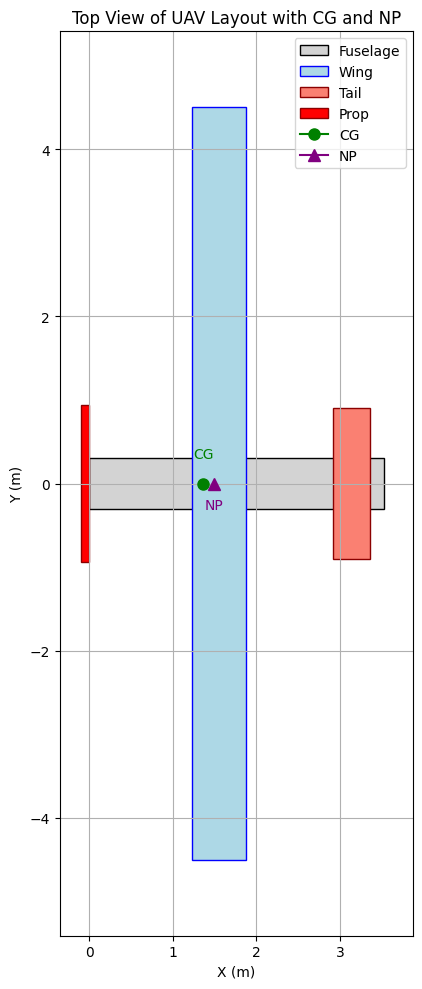

In [75]:


components, components_z = estimate_component_positions(predrop, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)

# components = {"avionics":components["avionics"], "Payload":components["internal_payload"]}

components = {}

# h_tail_le_position = predrop["cruiseout_cg_from_nose_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]

plot_uav_top_view(
    fuselage_length=predrop["fuselage_body_length_m"],
    fuselage_width=predrop["fuselage_body_width_m"],
    wing_span=predrop["wing_span_m"],
    wing_chord=predrop["chord_m"],
    wing_le_position=predrop["wing_le_position_m"],
    tail_span=predrop["h_tail_span_m"],
    tail_chord=predrop["h_tail_chord_m"],
    tail_le_position=predrop["x_ht_le_m"],
    components=components,
    cg_position=predrop["cruiseout_cg_from_nose_m"],
    np_position=predrop["neutral_point_m"],
)



In [32]:
predrop["x_ht_le_m"], h_tail_le_position

(5.91243440340273, 5.879785746000296)

In [43]:
wing_ac = predrop["wing_le_position_m"] + 0.25*predrop["chord_m"]

In [26]:
predrop["cruiseout_angle_of_attack_deg"], predrop["cruiseout_cl"]

(4.868865030674849, 0.8000000000000003)

In [32]:
cl_row = get_row_for_cl(deflections_dict["cruise_0"], predrop["cruiseout_cl"])

In [44]:
new_wing_ac = wing_ac - (cl_row['CM']/cl_row['CL']) * predrop["chord_m"]

In [45]:
new_wing_ac

3.1171988536768254

In [49]:
neutral_point_m = wing_ac + (assumed_and_set["horizontal_tail_volume_coefficient"] * predrop["chord_m"])
(neutral_point_m - predrop["cruiseout_cg_from_nose_m"]) / predrop["chord_m"]

0.16292630232487976

In [50]:
neutral_point_m = new_wing_ac + (assumed_and_set["horizontal_tail_volume_coefficient"] * predrop["chord_m"])
(neutral_point_m - predrop["cruiseout_cg_from_nose_m"]) / predrop["chord_m"]

0.23238949250892843

In [38]:
eta_h = calculate_eta_h(predrop, phase="loiter")
ht_downwash_efficiency_coeff = 0.5
phase_for_delta = "cruise"
phase = "cruiseout"
cl_row = get_row_for_cl(deflections_dict[f"{phase_for_delta}_0"], predrop[f"{phase}_cl"])

wing_ac = predrop["wing_le_position_m"] + 0.25*predrop["chord_m"]
# new_wing_ac = wing_ac - (cl_row['CM']/cl_row['CL']) * predrop["chord_m"]
new_wing_ac = wing_ac - (get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CL", 0.1)) * predrop["chord_m"]
# new_wing_ac = wing_ac - (get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CL", 0.1)) * predrop["chord_m"]

neutral_point_m = new_wing_ac + eta_h * assumed_and_set["horizontal_tail_volume_coefficient"] * predrop["chord_m"] * (1-ht_downwash_efficiency_coeff)

In [41]:
x_cg = predrop[f"{phase}_cg_from_nose_m"]
h_np = (neutral_point_m - predrop["wing_le_position_m"]) / predrop["chord_m"]
h_cg = (x_cg - predrop["wing_le_position_m"]) / predrop["chord_m"]
static_margin = h_np - h_cg
static_margin

-0.24317563038471646

In [31]:
get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CM", 0.1), cl_row["CM"]
get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CL", 0.1), cl_row["CL"]

(0.13039999999999996, 0.7999999999999998)

In [44]:
new_wing_ac - wing_ac

0.034552800528590666

In [37]:
get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CM", 0.1) / get_cl_alpha_at(deflections_dict[f"{phase_for_delta}_0"], predrop['cruiseout_angle_of_attack_deg'], "CL", 0.1)

-0.03680981595092035